In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

In [6]:
def binary_square(img_size=28,
                  sqr_size=10):
    img = np.zeros((img_size, img_size), dtype=np.int)
    x, y = tuple(np.random.randint(0, img_size - sqr_size, size=2))
    img[x: x + sqr_size, y: y + sqr_size] = 1

    return img

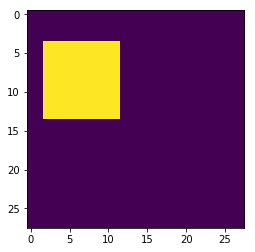

In [7]:
img = binary_square()
imshow(img)

In [8]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)